# Aquifer Storage and Recovery with buoyancy in a multi-layer system with MODFLOW6 and Flopy

In this section, we will learn how to simulate an ASR system with multiple layers including the effect of buoyancy.

In [ ]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 3) # set default figure size
import flopy as fp  # import flopy and call it fp

## Description of the flow problem
Consider radial flow in a confined aquifer. The aquifer extends in the $r$ direction from $r=0$ to $r=R$, where $R$ is chosen far enough away not to effect the solution.  Water is injected by the well at a rate $Q$. The head is fixed at $r=R$ to $h_R$. Flow is considered to be at steady state instantaneously. 

The initial salt concentration is equal to $c_s$ everywhere. Injection of fresh water with concentration $c_f$ starts at $t=0$ and last for $t_\text{in}$ days, after which water is extracted at the same rate $Q$ for $t_\text{out}$ days.

The density $\rho$ of the water is approximated using the following linear relation:
\begin{equation}
\rho = \frac{\text{d}\rho}{\text{d}c}(c-c_\text{ref}) + \rho_\text{ref}
\end{equation}
where the reference concentration is $c_\text{ref}=0$ and the reference density is $\rho_\text{ref}=1000$ kg/m$^3$ (i.e., freshwater) and $\frac{\text{d}\rho}{\text{d}c}$ is the specified gradient such that $c=35$ kg/m$^3$ results in a density of 1025 kg/m$^3$.  

The parameters are the same as the notebook for radial flow in a single-layer aquifer. 

Changes in the parameter block are:
* Model name

In [ ]:
# domain size and boundary conditions
L = 80 # length of domain, m
hL = 0 # head at right side of domain

# aquifer parameters
k = 20 # hydraulic conductivity, m/d
H = 20 # aquifer thickness, m
npor = 0.35 # porosity, -

# flow
Q = 500 # injection and extraction rage, m^3/d

# transport
alphaL = 0.5 # longitudinal dispersivity in horizontal direction
alphaT = alphaL / 10
diffusion_coef = 0

# concentration
cs = 35 # initial concentration, g/L (=kg/m^3)
cf = 0 # concentration injected water, g/L

# buoyancy
rhoref = 1000 # reference density, kg/m^3
cref = 0 # reference concentration, kg/m^3
drhodc = 0.7143  # Slope of the density-concentration line

# space discretization
delr = 0.2 # length of cell along row (in x-direction), m
delc = 1 # width of cells normal to plane of flow (in y-direction), m
nlay = 10
z = np.linspace(0, -H, nlay + 1) # top and bottom(s) of layers
zc = 0.5 * (z[:-1] + z[1:]) # center so cells, used for contouring
nrow = 1 # number of rows
ncol = round(L / delr) # number of columns

# radialize parameters:
theta = 2 * np.pi
r = np.cumsum(delr * np.ones(ncol)) - 0.5 * delr # rightside of cell minus half the cell length
krad = k * r * theta * np.ones((nlay, nrow, ncol))
nporrad = npor * r * theta * np.ones((nlay, nrow, ncol))

# time discretization
tin = 30 # injection time, d
delt = 0.1 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer
tout = 30 # extraction time, d
delt = 0.1 # time step, d
nstepout = round(tout / delt) # computed number of steps during extraction, integer

# model name and workspace
modelname = 'modelbuoy' # name of model
gwfname = modelname + 'f' # name of flow model
gwtname = modelname + 't' # name of transport model
modelws = './' + modelname # model workspace to be used

## Create Simulation
Changes in the simulation: None.

In [ ]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='../bin/mf6', # absolute path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=2, # number of stress periods 
                          perioddata=[[tin, nstepin, 1],
                                      [tout, nstepout, 1]], # period length, number of steps, timestep multiplier
                         )

## Create groundwater flow model (`gwf`)
Changes in the groundwater flow model:
* Buoyancy is specified with the buoyancy package

In [ ]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=krad, # horizontal k value
                                k33=krad / 10,
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hL, # initial head used for iterative solution
                            )

# wells
wellin = []
wellout = []
for ilay in range(nlay):
    wellin.append([(ilay, 0, 0),  Q / nlay, cf])  # [(layer, row, col), U, concentration]
    wellout.append([(ilay, 0, 0),  -Q / nlay, cf]) # specified concentration is not used, but must be specified 
wel_spd = {0: wellin, 1: wellout} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd = []
for ilay in range(nlay):
    chd.append([(ilay,  0,  ncol-1), hL, cs]) # [(layer, row, col), head, concentration]
chd_spd  = {0: chd, 1: chd}    # Stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )

# buoyancy
buy = fp.mf6.ModflowGwfbuy(model=gwf,
                           packagedata=[0, drhodc, cref, gwtname, 'CONCENTRATION'],
                           denseref=rhoref, # reference concentration
                           nrhospecies=1, # number of species
                           density_filerecord=f"{gwf.name}.dst", # file name
                           pname='BUY1', 
                          )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

## Create groundwater transport model (`gwt`)
Changes in the transport model: None.

In [ ]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim,
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, 
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=nporrad, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")]
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="TVD",  # use Total Variation Diminishing (TVD)
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL,
                           ath1=alphaT, 
                           diffc=diffusion_coef,
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

Changes in interaction: None

In [ ]:
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name , 
                     exgmnameb=gwt.name , 
                     filename=f"{modelname}.gwfgwt",
                    );

## Write input files and solve model
We are finally ready to write the input files and solve the model. First, we write the input files. This will print a lot of information to the screen (which can be silenced if desired with the `silent=True` option).
Note that `flopy` created a subdirectory called `model1` (the `modelws` defined in one of the first code cells of this notebook) that contains all the MODFLOW input files. Use your file explorer to see what files were created. You may also inspect the contents of some of the files. Their exact format is specified in the USGS manual mfio.pdf. FloPy takes care of all the painstaking work that is required to create these input files by hand!

Finally, we solve the model. If all goes well, the final statement on the screen is `Normal termination of simulation.`

In [ ]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

## Read concentration data and make contour plot of the concentration

In [30]:
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

(0.0, 50.0)

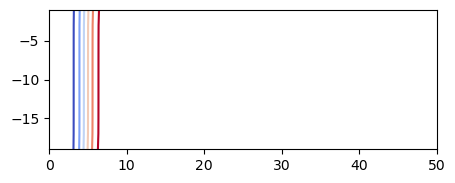

In [31]:
plt.subplot(111, aspect=1)
plt.contour(r, zc, c[10], np.arange(5, 35, 5), cmap='coolwarm')
plt.xlim(0, 50)

In [32]:
from ipywidgets import interact

def contour(tstep):
    plt.subplot(111, xlim=(0, 50), ylim=(-20, 0), xlabel='r (m)', ylabel='z (m)')
    plt.contour(r, zc, c[tstep], np.arange(5, 35, 5), cmap='coolwarm')

interact(contour, tstep=(0, nstepin + nstepout - 1, 1));

C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWar

interactive(children=(IntSlider(value=299, description='tstep', max=599), Output()), _dom_classes=('widget-int…

## Homework

### Problem 3
Compute and report the mass balance during the last time step of extraction

### Problem 4
Compute and report the recovery efficiency of cycle 1 and the recovery efficiency of cycle 2 using $c_\text{limit}=1$ g/L. Note that $c_\text{limit}$ is the limit of the average concentration of the water pumped by the well. 

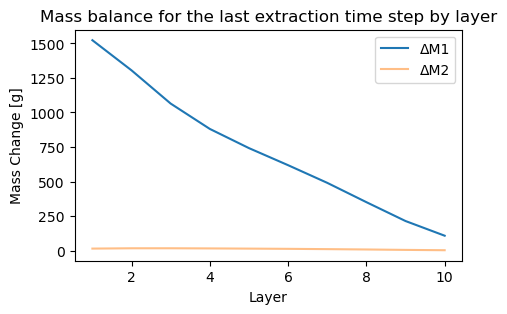

In [33]:
# Calculate mass balance during the last time step of extraction
itime_last_extraction = np.abs(times - (tin + tout)).argmin()

# Initialize delM1_last_extraction and delM2_last_extraction for the last time step of extraction
delM1_last_extraction = (-Q * c[itime_last_extraction,:, 0] + Q * c[itime_last_extraction,:, -1]) * delt
delM2_last_extraction = np.zeros(nlay)

for ilay in range(nlay):
    for j in range(0,400):
        value = (c[itime_last_extraction, ilay, j] - c[itime_last_extraction - 1, ilay, j]) * H * npor * delr
        delM2_last_extraction[ilay] += value

# Compare delM2_last_extraction to delM1_last_extraction
mass_balance_error = delM1_last_extraction - delM2_last_extraction

layers = np.arange(1, nlay + 1)

# Plot the results for the last extraction time step per layer
plt.figure()
plt.plot(layers, delM1_last_extraction, label='ΔM1')
plt.plot(layers, delM2_last_extraction, label='ΔM2', alpha=0.5)
plt.legend()
plt.xlabel('Layer')
plt.ylabel('Mass Change [g]')
plt.title('Mass balance for the last extraction time step by layer')
plt.show()

In [36]:
climit = 1

# initial condition for the first cycle
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# write model, solve model, and read concentration data
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

cobj = gwt.output.concentration() # get handle to binary concentration file
c0 = cobj.get_alldata().squeeze() # get the concentration data from the file

# Find the time when the concentration at the well exceeds the limit for the first cycle
time_at_limit_cycle1 = None
for itime in range(400, 800):
    if np.any(c0[itime, 0] > climit):
        time_at_limit_cycle1 = times[itime]
        break

# Calculate recovery efficiency for the first cycle
recovery_efficiency_cycle1 = ((time_at_limit_cycle1 - tin) * Q) / (tin * Q)
print(f'Recovery Efficiency for Cycle 1: {recovery_efficiency_cycle1 * 100:.1f}%')

# initial condition for the second cycle
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=c0[itime - 1], # initial concentration
                            ) 

# write model, solve model, and read concentration data for the second cycle
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

cobj = gwt.output.concentration() # get handle to binary concentration file
c1 = cobj.get_alldata().squeeze() # get the concentration data from the file

# Find the time when the concentration at the well exceeds the limit for the second cycle
time_at_limit_cycle2 = None
for itime in range(400, 800):
    if np.any(c1[itime, 0] > climit):
        time_at_limit_cycle2 = times[itime]
        break

# Calculate recovery efficiency for the second cycle
recovery_efficiency_cycle2 = ((time_at_limit_cycle2 - tin) * Q) / (tin * Q)
print(f'Recovery Efficiency for Cycle 2: {recovery_efficiency_cycle2 * 100:.1f}%')

Model solved successfully
Recovery Efficiency for Cycle 1: 33.7%
Model solved successfully
Recovery Efficiency for Cycle 2: 33.7%
